In [1]:
import numpy as np
import pickle
import pandas as pd
import matplotlib.pyplot as plt
from psiam_tied_dv_map_utils import psiam_tied_data_gen_wrapper_V2
from joblib import Parallel, delayed

In [2]:
with open('only_tied_right_trunc_vbmc.pkl', 'rb') as f:
    vp = pickle.load(f)

In [3]:
# read out_LED.csv as dataframe
og_df = pd.read_csv('../out_LED.csv')
# chose non repeat trials - 0 or 2 or missing
df = og_df[ og_df['repeat_trial'].isin([0,2]) | og_df['repeat_trial'].isna() ]

# only session type 7
session_type = 7    
df = df[ df['session_type'].isin([session_type]) ]

# training level 16
training_level = 16
df = df[ df['training_level'].isin([training_level]) ]

In [4]:
with open('../fitting_aborts/post_led_censor_test_vbmc.pkl', 'rb') as f:
    vp_p = pickle.load(f)

In [5]:
vp_sample = vp_p.sample(int(1e6))[0]
V_A = np.mean(vp_sample[:,0])
theta_A = np.mean(vp_sample[:,1])
t_motor = 0.04
t_A_aff = np.mean(vp_sample[:,2]) - t_motor

In [6]:
dt = 1e-3
dB = np.sqrt(dt)
N_sim = 50_000
N_print = N_sim + 10

t_stim_sampled = np.random.choice(df['intended_fix'], N_sim, replace=False)

def proactive_process():
    dv = 0
    t = t_A_aff
    while True:
        dv += V_A*dt + np.random.normal(0, dB)
        t += dt

        if dv > theta_A:
            return t + t_motor

In [7]:
pro_rt = Parallel(n_jobs=30)(delayed(proactive_process)() for _ in range(N_sim))

In [8]:
pro_rt_wrt_stim = pro_rt - t_stim_sampled

In [9]:
bins_stim = np.arange(-2,5,0.01)
bins_fix = np.arange(0,4,0.01)

Text(0.5, 1.0, 'proactive RT wrt stim')

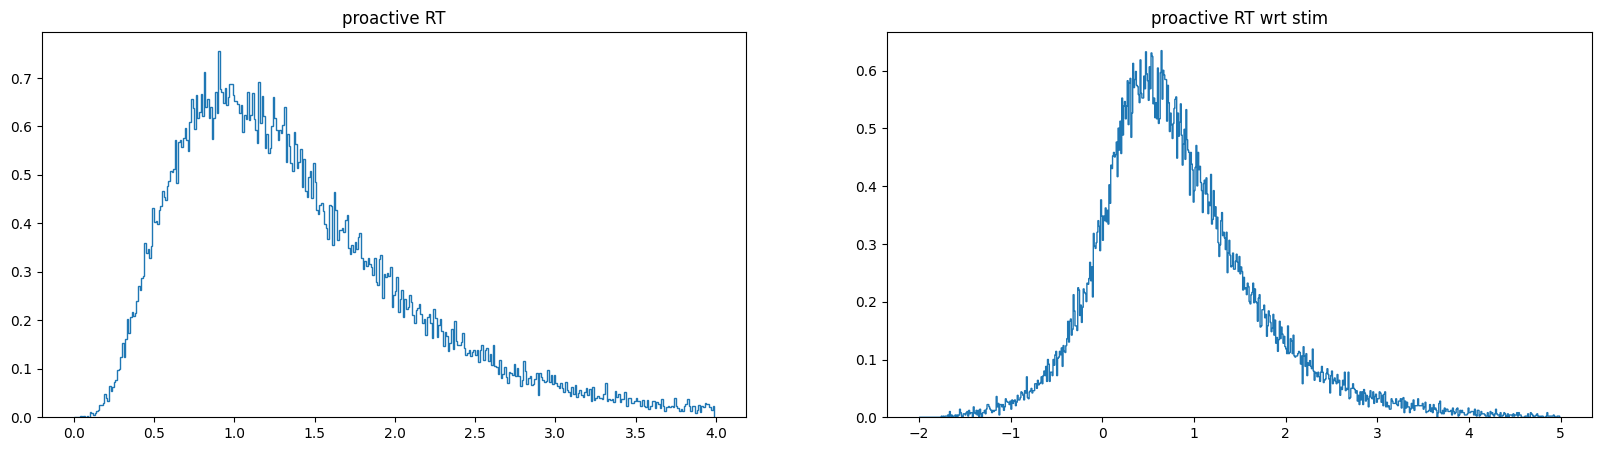

In [10]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.hist(pro_rt, bins=bins_fix, density=True, histtype='step')
plt.title('proactive RT')

plt.subplot(1,2,2)
plt.hist(pro_rt_wrt_stim, bins=bins_stim, density=True, histtype='step')
plt.title('proactive RT wrt stim')


In [11]:
# data with trunc aborts
df_led_off = df [ df['LED_trial'] == 0]
df_led_off = df_led_off[~((df_led_off['timed_fix'] < 0.3) & (df_led_off['timed_fix'] < df_led_off['intended_fix']))]
df_led_off_all_rt = df_led_off['timed_fix'] - df_led_off['intended_fix']


In [12]:
# 
trunc_aborts_sim = [rt for rt in pro_rt if rt > 0.3]
trunc_aborts_sim_wrt_stim = [rt - np.random.choice(df['intended_fix']) for rt in trunc_aborts_sim]

Text(0.5, 1.0, 'only proactive,  all rt data - no aborts < 0.3')

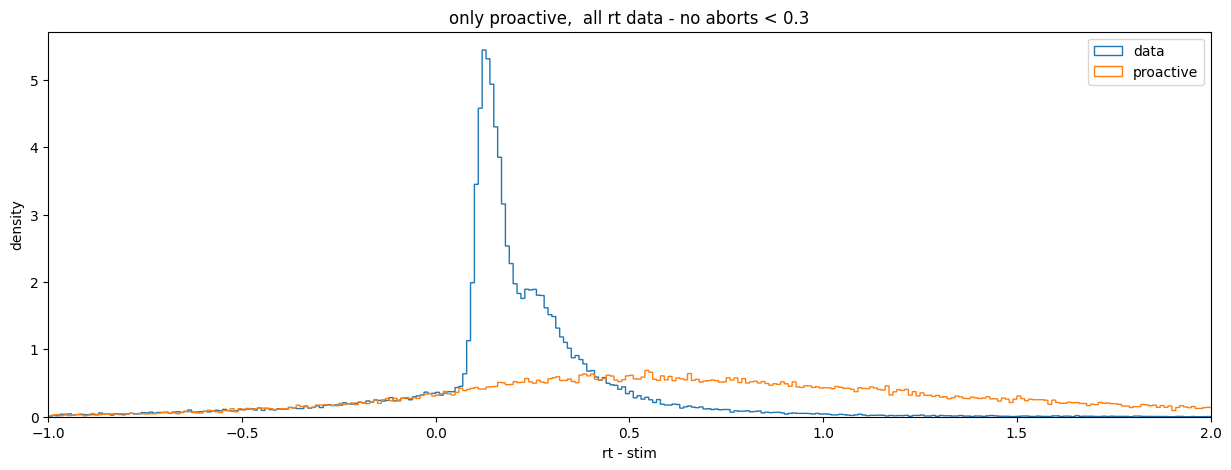

In [13]:
plt.figure(figsize=(15,5))
plt.hist(df_led_off_all_rt, bins=bins_stim, density=True, histtype='step', label='data');
plt.hist(trunc_aborts_sim_wrt_stim, bins=bins_stim, density=True, histtype='step', label='proactive');
plt.xlim(-1,2)
plt.legend()
plt.xlabel('rt - stim')
plt.ylabel('density')
plt.title('only proactive,  all rt data - no aborts < 0.3')

In [66]:
vp_sample_2 = vp.vp.sample(int(1e6))[0]

In [67]:
rate_lambda = np.mean(vp_sample_2[:,0])
T0 = np.mean(vp_sample_2[:,1])
theta_E = np.mean(vp_sample_2[:,2])

t_E = np.mean(vp_sample_2[:,3])
Z_E = np.mean(vp_sample_2[:,4])
L = np.mean(vp_sample_2[:,5])

In [ ]:
# find ABL and ILD
ABL_arr = df['ABL'].unique()
ILD_arr = df['ILD'].unique()


# sort ILD arr in ascending order
ILD_arr = np.sort(ILD_arr)
ABL_arr = np.sort(ABL_arr)

print('ABL:', ABL_arr)
print('ILD:', ILD_arr)

In [ ]:
dt = 1e-3
N_sim = 50_000
N_print = N_sim + 10

t_stim_sampled = np.random.choice(df['intended_fix'], N_sim, replace=False)

sim_results = Parallel(n_jobs=30)(delayed(psiam_tied_data_gen_wrapper_V2)(V_A, theta_A, ABL_arr, ILD_arr, rate_lambda, T0, theta_E, Z_E, t_A_aff, t_E, t_motor, L, \
                                                                         t_stim_sampled[iter_num], iter_num, N_print, dt) for iter_num in range(N_sim)) 

In [70]:
rt_arr = [res['rt'] - res['t_stim'] for res in sim_results]
rt_arr_no_aborts = [ res['rt'] - res['t_stim'] for res in sim_results if not(res['rt'] < res['t_stim'] and res['rt'] < 0.3)]

In [ ]:
len(rt_arr) - len(rt_arr_no_aborts)

In [ ]:
bins = np.arange(-2,2,0.01)

plt.hist(rt_arr, bins, label='all trials', density=True, color='b', histtype='step')
plt.hist(rt_arr_no_aborts, bins, label='no aborts < 0.3', color='r', density=True, histtype='step', linestyle='--')
plt.legend(loc='upper right')
plt.xlabel('rt - tstim')
plt.ylabel('denisty')